
自己写一个 mnist 手写数字判断的网络。 用 pytorch 实现


数据集地址： https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true

解压后： 

```
mnist_png
├── testing
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
└── training
    ├── 0
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    └── 9
```

分为 training 和 testing， 各10个目录，分别表示数字 0 ~ 9

In [1]:
# 了解数据集

from pathlib import Path

mnist_path = Path('mnist_png/')

_dataset = ['training', 'testing']
_labels = list(range(0, 10))

for x in _dataset:
    acc = 0
    for l in _labels:
        p = mnist_path / x / str(l)
        images = list(p.glob('*.png'))
        print(p, len(images))
        acc += len(images)
    print(acc)

# 训练集 60000，平均每个数字 5000+ 
# 测试集 10000，平均每个数字 1000张 
# for _p1 in mnist_path.iterdir():
#     for _p2 in _p1.iterdir():
#         print(_p2, len(list(_p2.glob('*.png'))))
#print(len(list(data_path.rglob('*.png'))))

mnist_png/training/0 5923
mnist_png/training/1 6742
mnist_png/training/2 5958
mnist_png/training/3 6131
mnist_png/training/4 5842
mnist_png/training/5 5421
mnist_png/training/6 5918
mnist_png/training/7 6265
mnist_png/training/8 5851
mnist_png/training/9 5949
60000
mnist_png/testing/0 980
mnist_png/testing/1 1135
mnist_png/testing/2 1032
mnist_png/testing/3 1010
mnist_png/testing/4 982
mnist_png/testing/5 892
mnist_png/testing/6 958
mnist_png/testing/7 1028
mnist_png/testing/8 974
mnist_png/testing/9 1009
10000


In [18]:
# 用 pytorch 加载数据集

from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

class MNIST(Dataset):
    """
    类似 torchvision.datasets.ImageFolder 的Dataset
    """
    def __init__(self, root, transform=None, preload=False):
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform
        
        root_path = Path(root)
        for fn in root_path.rglob('*.png'):
            label = fn.parts[-2]
            self.filenames.append((fn, int(label)))
            
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


trainset = MNIST(root='mnist_png/training', 
                 preload=True, transform=transforms.ToTensor(),)
testset = MNIST(root='mnist_png/testing',
                preload=True, transform=transforms.ToTensor(),)

In [19]:
print(len(trainset))
print(len(testset))

60000
10000


In [20]:
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

tensor(7) tensor(1) tensor(1) tensor(3) tensor(1) tensor(9) tensor(6) tensor(7) tensor(9) tensor(8) tensor(3) tensor(9) tensor(8) tensor(2) tensor(1) tensor(5)


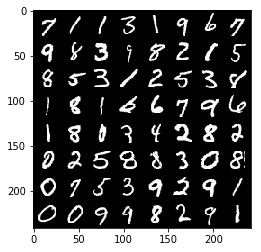

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

torch.Size([1, 28, 28])
torch.Size([3, 28, 28])
torch.Size([1, 3, 28, 28])
torch.Size([3, 28, 28])


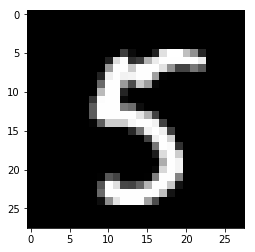

In [17]:
import torch
_tensor = trainset[0][0]
print(_tensor.size())
_tensor = torch.cat((_tensor, _tensor, _tensor), 0)
print(_tensor.size())
_tensor = _tensor.view(1, _tensor.size(0), _tensor.size(1), _tensor.size(2))
print(_tensor.size())
_tensor = _tensor.squeeze()
print(_tensor.size())

plt.imshow(_tensor.numpy().transpose((1, 2, 0)))

In [25]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # conv layers: feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        # fc layers: classifier
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda:3')
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:

from time import time


def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

def train(epoch, log_interval=100):
#     model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        model.train()  # set training mode
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            # bring data to the computing device, e.g. GPU
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data)
            # compute loss: negative log-likelihood
            loss = F.nll_loss(output, target)
            
            # backward pass
            # clear the gradients of all tensors being optimized.
            optimizer.zero_grad()
            # accumulate (i.e. add) the gradients from this forward pass
            loss.backward()
            # performs a single optimization step (parameter update)
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
            
        end = time()
        print('{:.2f}s'.format(end-start))
        test() # evaluate at the end of epoch


In [27]:
train(5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299714
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.318877
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.243235
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.181257
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.057456
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.711458
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.475947
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.276271
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.904073
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.056284
4.41s

Test set: Average loss: 0.5422, Accuracy: 8647/10000 (86%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.746869
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.789950
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.776248
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.625902
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.696920
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.696689
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.631997
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.612421
Train Epoch: 1 [55168/60000 (92%)]	Loss: 